In [52]:
import os, sys
import glob
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import tangram as tg
import torch

from pathlib import Path
from anndata import AnnData, read_h5ad

In [53]:
# Add Sanja's Tangram to the path
sys.path.append('/mnt/home/adaly/sTangram/')
from tangram_old import utils
from tangram_old import mapping_utils
from tangram_old import mapping_optimizer
from tangram_old import plot_utils

In [54]:
### Helper Functions ###

def downsample_to_smallest_category(
        adata,
        column="sample_short",
        random_state=None,
        min_cells=15,
        keep_small_categories=False
) -> sc.AnnData:
    """
    returns an annData object in which all categories in 'column' have
    the same size

    column
        column with the categories to downsample
    min_cells
        Minimum number of cells to downsample.
        Categories having less than `min_cells` are discarded unless
        keep_small_categories is True
    keep_small_categories
        Be default categories with less than min_cells are discarded.
        Set to true to keep them
    """
    counts = adata.obs[column].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logging.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = adata.obs.index.isin(
                    adata.obs[adata.obs[column] == sample].index)
            else:
                continue
        else:
            sel = adata.obs.index.isin(
                adata.obs[adata.obs[column] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
    logging.info(
        "The cells in category {!r} had been down-sampled to have each {} cells. "
        "The original counts where {}".format(column, min_size, dict(counts))
    )
    return adata[sample_selection].copy()

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

In [59]:
# Load a representative ST data file & parse gene names
#st_datfile = '/mnt/home/adaly/ceph/datasets/splotch_science_rerun/count_matrices_mouse_0305/CN51_C2_1_stdata_aligned_counts_IDs.txt.unified.tsv'
#st_df = pd.read_csv(st_datfile, header=0, index_col=0, sep='\t')
#st_genes = st_df.index.values

lambda_datfile = '/mnt/home/adaly/ceph/datasets/splotch_science_rerun/lambda_means_mouse/CN51_C2_1_lambdas.csv'
lambda_df = pd.read_csv(st_datfile, header=0, index_col=0, sep=',')
st_genes = lambda_df.index.values

print(len(st_genes), 'genes')

11154 genes


Load and preprocess single-cell data

In [61]:
sc_datfile = '../data/GSM3017261_20000_SC_nuclei.h5ad'
sc_all = sc.read_h5ad(sc_datfile)
sc.pp.normalize_total(sc_all)

# Only include genes present in ST data
sc_all = sc_all[:, sc_all.var_names.isin(st_genes)]

sc.pp.log1p(sc_all)  # log(x+1) transform count data
sc.pp.scale(sc_all)  # scale to unit variance and zero mean

# Downsample sc data for memory purposes -- discard BG cells; focus on predicting Neuron/Glia ratio
sc_down = downsample_to_smallest_category(sc_all, column='csplotch_annot',
                                         random_state=7, min_cells=1000, keep_small_categories=True)
shared_genes = sc_down.var_names
print(sc_down)
print(len(shared_genes), 'genes shared between SC and ST')

INFO:root:The cells in category 'csplotch_annot' had been down-sampled to have each 6790 cells. The original counts where {'BG': 780, 'Glia': 6790, 'Neuron': 14064}


AnnData object with n_obs × n_vars = 14360 × 10378
    obs: 'sample_type', 'sc_cluster', 'csplotch_annot'
    var: 'mean', 'std'
    uns: 'log1p'
10378 genes shared between SC and ST


In [62]:
# Calculate HVGs using raw snRNA count data

# For some reason, fails on rusty:
# SystemError: CPUDispatcher(<function sparse_mean_var_major_axis at 0x15550c0f11e0>) returned a result with an error set
# (see: https://githubmemory.com/repo/theislab/scanpy/issues/1995)

#sc_raw = sc.read_h5ad(sc_datfile)
#sc.pp.highly_variable_genes(sc_raw, flavor='seurat_v3', n_top_genes=500)
#hvgs = list(sc_raw.var_names[sc_raw.var['highly_variable']])

hvgs = pickle.load(open('rosenberg_sc_hvgs.p', 'rb'))

Load and preprocess ST data

In [82]:
counts_dir = '/mnt/home/adaly/ceph/datasets/splotch_science_rerun/count_matrices_mouse_0305/'
cellcomp_dir = '/mnt/home/adaly/ceph/datasets/csplotch_mouse_st/celltype_annotations/'
lambdas_dir = '/mnt/home/adaly/ceph/datasets/splotch_science_rerun/lambda_means_mouse/'

stdata_dict = {}

# We'll limit ourselves to WT p100 and G93A p100 for now, since we have IF data on these to check against
metafile = os.path.expanduser('~/ceph/datasets/csplotch_mouse_st/metadata_compositional_WTG93A.tsv')
metadata = pd.read_csv(metafile, sep='\t')
wt_p30 = metadata['Level 1'] == 'WT p30'
g93a_p30 = metadata['Level 1'] == 'G93A p30'
metadata = metadata[np.logical_or(wt_p30, g93a_p30)]

for i in range(len(metadata)):
    row = metadata.iloc[i]
    cfile = os.path.join(counts_dir, Path(row['Count file']).name)

    sample_name = Path(cfile).name.split('_stdata')[0]
    array_name = '_'.join(sample_name.split('_')[:2])
        
    afile = os.path.join(cellcomp_dir, array_name + '_celltype_annotations.csv')
    if os.path.exists(afile):
        annot_df = pd.read_csv(afile, header=0, index_col=0, sep=',')
        #count_df = pd.read_csv(cfile, header=0, index_col=0, sep='\t')
        
        lambda_file = os.path.join(lambdas_dir, '%s_lambdas.csv' % sample_name)
        count_df = pd.read_csv(lambda_file, sep=',', header=0, index_col=0)
        
        # Filter out spots missing annotation data
        shared = set(count_df.columns.values).intersection(set(annot_df['x_y']))
        count_df = count_df[shared]
                
        # Construct AnnData object with per-spot cell counts
        cell_counts, x_coords, y_coords = [], [], []
        for cstr in count_df.columns:
            row = annot_df[annot_df['x_y']==cstr]
            tot = row['MN_count'].values + row['Glia_count'].values + row['OtherN_count'].values
            cell_counts.append(tot[0])
            
            x, y = map(float, cstr.split('_'))
            x_coords.append(x)
            y_coords.append(y)
            
        obs = pd.DataFrame({'cell_count': cell_counts, 'x': x_coords, 'y': y_coords}, index=count_df.columns)
        var = pd.DataFrame(index=count_df.index)        
        stdata = AnnData(X=count_df.values.T, obs=obs, var=var)
                
        if obs['cell_count'].sum() == 0:
            print('Skipping %s (no cells counted)' % sample_name)
            continue

        # Only keep genes shared between the two modalities
        stdata = stdata[:, stdata.var_names.isin(shared_genes)]
        
        # Normalize number of counts per spot
        sc.pp.normalize_total(stdata, target_sum=1e4)
        sc.pp.log1p(stdata)
        
        stdata_dict[sample_name] = stdata

Perform Tangram mapping

In [83]:
hyperparam = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cell_mappings = {}

for key in stdata_dict.keys():
    print(key)
    st_sample = stdata_dict[key]
    print('Number of cells in spatial data:', sum(st_sample.obs.cell_count))
    print('Number of cells in scRNA data:', len(sc_down.obs.index))
    
    # Remove 0-count genes, ensure same genes present in same order
    adata_cells, adata_space = mapping_utils.pp_adatas(sc_down, st_sample, genes=hvgs)
    
    # Perform Tangram mapping
    ad_map = mapping_utils.map_cells_to_space(
        adata_cells = adata_cells,
        adata_space = adata_space,
        mode = 'cells',
        num_epochs = 1000,
        scale = False,
        d = np.array(st_sample.obs.cell_count) / st_sample.obs.cell_count.sum(),
        device = device,
        target_count = stdata.obs.cell_count.sum(),
        **hyperparam)
    ad_map.write_h5ad('tangram_map_%s.h5ad' % key)
    
    # Annotation transfer
    df_classes = tg.ut.one_hot_encoding(adata_cells.obs.csplotch_annot)
    df_vox_cells = pd.DataFrame({
        'x' : ad_map.var.x, 
        'y' : ad_map.var.y, 
        'cell_n' : ad_map.var.cell_count})
    resulting_voxels = np.argmax(ad_map.X, axis=1)  # spots to which cells are most likely assigned
    
    filtered_voxels_to_types = []  # Map of (spot_ind, cell_type)
    for i in range(len(resulting_voxels)):
        if ad_map.uns['F_out'][i] > 0.9:
            spot_ind = resulting_voxels[i]
            filtered_voxels_to_types.append((spot_ind, adata_cells.obs.csplotch_annot[i]))
    
    # Add columns tracking number of cells of each type in each spot
    for cind, ctype in enumerate(df_classes):
        df_vox_cells[ctype] = 0
    for spot_ind, cell_type in filtered_voxels_to_types:
        df_vox_cells.iloc[spot_ind, df_vox_cells.columns.get_loc(cell_type)] += 1
    
    cell_mappings[key] = df_vox_cells

CN68_E1
Number of cells in spatial data: 1404
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.132, KL reg: 0.110
Score: 0.519, KL reg: 0.001
Score: 0.530, KL reg: 0.001
Score: 0.536, KL reg: 0.001
Score: 0.540, KL reg: 0.001
Score: 0.541, KL reg: 0.001
Score: 0.544, KL reg: 0.001
Score: 0.546, KL reg: 0.000
Score: 0.547, KL reg: 0.000
Score: 0.547, KL reg: 0.000


INFO:root:Saving results..


CN69_C1
Number of cells in spatial data: 1514
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.126, KL reg: 0.186
Score: 0.534, KL reg: 0.004
Score: 0.541, KL reg: 0.003
Score: 0.542, KL reg: 0.003
Score: 0.544, KL reg: 0.003
Score: 0.544, KL reg: 0.003
Score: 0.545, KL reg: 0.003
Score: 0.546, KL reg: 0.003
Score: 0.548, KL reg: 0.003
Score: 0.548, KL reg: 0.003


INFO:root:Saving results..


CN69_C2
Number of cells in spatial data: 900
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.127, KL reg: 0.239
Score: 0.544, KL reg: 0.006
Score: 0.562, KL reg: 0.005
Score: 0.568, KL reg: 0.005
Score: 0.570, KL reg: 0.005
Score: 0.572, KL reg: 0.005
Score: 0.573, KL reg: 0.005
Score: 0.574, KL reg: 0.005
Score: 0.574, KL reg: 0.005
Score: 0.575, KL reg: 0.005


INFO:root:Saving results..


CN69_D1
Number of cells in spatial data: 1621
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.133, KL reg: 0.105
Score: 0.554, KL reg: 0.001
Score: 0.565, KL reg: 0.001
Score: 0.570, KL reg: 0.000
Score: 0.572, KL reg: 0.000
Score: 0.573, KL reg: 0.000
Score: 0.574, KL reg: 0.000
Score: 0.574, KL reg: 0.000
Score: 0.575, KL reg: 0.000
Score: 0.576, KL reg: 0.000


INFO:root:Saving results..


CN69_D2
Number of cells in spatial data: 1485
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.130, KL reg: 0.113
Score: 0.553, KL reg: 0.000
Score: 0.562, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.567, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.570, KL reg: 0.000
Score: 0.571, KL reg: 0.000
Score: 0.572, KL reg: 0.000


INFO:root:Saving results..


CN69_E1
Number of cells in spatial data: 1895
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.139, KL reg: 0.119
Score: 0.581, KL reg: 0.000
Score: 0.587, KL reg: 0.000
Score: 0.591, KL reg: 0.000
Score: 0.594, KL reg: 0.000
Score: 0.595, KL reg: 0.000
Score: 0.596, KL reg: 0.000
Score: 0.596, KL reg: 0.000
Score: 0.597, KL reg: 0.000
Score: 0.598, KL reg: 0.000


INFO:root:Saving results..


CN78_C1
Number of cells in spatial data: 2606
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.127, KL reg: 0.179
Score: 0.500, KL reg: 0.002
Score: 0.515, KL reg: 0.001
Score: 0.519, KL reg: 0.001
Score: 0.521, KL reg: 0.001
Score: 0.522, KL reg: 0.001
Score: 0.522, KL reg: 0.001
Score: 0.524, KL reg: 0.001
Score: 0.524, KL reg: 0.001
Score: 0.525, KL reg: 0.001


INFO:root:Saving results..


CN78_C2
Number of cells in spatial data: 3335
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.130, KL reg: 0.171
Score: 0.532, KL reg: 0.001
Score: 0.546, KL reg: 0.001
Score: 0.551, KL reg: 0.001
Score: 0.553, KL reg: 0.001
Score: 0.554, KL reg: 0.001
Score: 0.556, KL reg: 0.001
Score: 0.556, KL reg: 0.001
Score: 0.557, KL reg: 0.001
Score: 0.558, KL reg: 0.000


INFO:root:Saving results..


CN79_C2
Number of cells in spatial data: 1832
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.124, KL reg: 0.105
Score: 0.512, KL reg: 0.000
Score: 0.523, KL reg: 0.000
Score: 0.524, KL reg: 0.000
Score: 0.524, KL reg: 0.000
Score: 0.524, KL reg: 0.000
Score: 0.526, KL reg: 0.000
Score: 0.526, KL reg: 0.000
Score: 0.526, KL reg: 0.000
Score: 0.526, KL reg: 0.000


INFO:root:Saving results..


CN79_D1
Number of cells in spatial data: 1355
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.142, KL reg: 0.179
Score: 0.528, KL reg: 0.000
Score: 0.549, KL reg: 0.000
Score: 0.556, KL reg: 0.000
Score: 0.557, KL reg: 0.000
Score: 0.558, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.559, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.560, KL reg: 0.000


INFO:root:Saving results..


CN79_D2
Number of cells in spatial data: 2083
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.131, KL reg: 0.147
Score: 0.510, KL reg: 0.001
Score: 0.524, KL reg: 0.001
Score: 0.527, KL reg: 0.000
Score: 0.529, KL reg: 0.000
Score: 0.529, KL reg: 0.000
Score: 0.530, KL reg: 0.000
Score: 0.530, KL reg: 0.000
Score: 0.531, KL reg: 0.000
Score: 0.531, KL reg: 0.000


INFO:root:Saving results..


CN80_C2
Number of cells in spatial data: 3628
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.134, KL reg: 0.218
Score: 0.506, KL reg: 0.001
Score: 0.524, KL reg: 0.001
Score: 0.532, KL reg: 0.000
Score: 0.536, KL reg: 0.000
Score: 0.537, KL reg: 0.000
Score: 0.540, KL reg: 0.000
Score: 0.541, KL reg: 0.000
Score: 0.542, KL reg: 0.000
Score: 0.544, KL reg: 0.000


INFO:root:Saving results..


CN80_D1
Number of cells in spatial data: 2928
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.142, KL reg: 0.144
Score: 0.517, KL reg: 0.001
Score: 0.531, KL reg: 0.000
Score: 0.537, KL reg: 0.000
Score: 0.541, KL reg: 0.000
Score: 0.542, KL reg: 0.000
Score: 0.541, KL reg: 0.000
Score: 0.542, KL reg: 0.000
Score: 0.542, KL reg: 0.000
Score: 0.543, KL reg: 0.000


INFO:root:Saving results..


CN80_D2
Number of cells in spatial data: 2534
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.135, KL reg: 0.151
Score: 0.501, KL reg: 0.001
Score: 0.515, KL reg: 0.001
Score: 0.522, KL reg: 0.001
Score: 0.525, KL reg: 0.001
Score: 0.529, KL reg: 0.001
Score: 0.529, KL reg: 0.001
Score: 0.530, KL reg: 0.001
Score: 0.531, KL reg: 0.001
Score: 0.531, KL reg: 0.001


INFO:root:Saving results..


CN80_E1
Number of cells in spatial data: 2098
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.150, KL reg: 0.151
Score: 0.539, KL reg: 0.001
Score: 0.556, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.564, KL reg: 0.000
Score: 0.565, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.566, KL reg: 0.000


INFO:root:Saving results..


CN81_C2
Number of cells in spatial data: 3449
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.132, KL reg: 0.093
Score: 0.539, KL reg: 0.000
Score: 0.547, KL reg: 0.000
Score: 0.554, KL reg: 0.000
Score: 0.555, KL reg: 0.000
Score: 0.558, KL reg: 0.000
Score: 0.564, KL reg: 0.000
Score: 0.566, KL reg: 0.000
Score: 0.569, KL reg: 0.000
Score: 0.570, KL reg: 0.000


INFO:root:Saving results..


CN81_E1
Number of cells in spatial data: 2656
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.140, KL reg: 0.084
Score: 0.547, KL reg: 0.001
Score: 0.557, KL reg: 0.001
Score: 0.566, KL reg: 0.000
Score: 0.570, KL reg: 0.000
Score: 0.571, KL reg: 0.000
Score: 0.572, KL reg: 0.000
Score: 0.572, KL reg: 0.000
Score: 0.574, KL reg: 0.000
Score: 0.575, KL reg: 0.000


INFO:root:Saving results..


CN92_C1
Number of cells in spatial data: 1456
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.140, KL reg: 0.147
Score: 0.556, KL reg: 0.001
Score: 0.568, KL reg: 0.001
Score: 0.573, KL reg: 0.001
Score: 0.576, KL reg: 0.001
Score: 0.577, KL reg: 0.001
Score: 0.578, KL reg: 0.001
Score: 0.579, KL reg: 0.001
Score: 0.580, KL reg: 0.001
Score: 0.582, KL reg: 0.001


INFO:root:Saving results..


CN92_C2
Number of cells in spatial data: 1236
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.140, KL reg: 0.130
Score: 0.537, KL reg: 0.001
Score: 0.548, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.553, KL reg: 0.000
Score: 0.556, KL reg: 0.000
Score: 0.558, KL reg: 0.000
Score: 0.559, KL reg: 0.000
Score: 0.558, KL reg: 0.000
Score: 0.559, KL reg: 0.000


INFO:root:Saving results..


CN92_D1
Number of cells in spatial data: 3219
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.133, KL reg: 0.181
Score: 0.502, KL reg: 0.001
Score: 0.517, KL reg: 0.001
Score: 0.522, KL reg: 0.001
Score: 0.524, KL reg: 0.001
Score: 0.526, KL reg: 0.001
Score: 0.526, KL reg: 0.001
Score: 0.527, KL reg: 0.001
Score: 0.527, KL reg: 0.001
Score: 0.525, KL reg: 0.001


INFO:root:Saving results..


CN92_E2
Number of cells in spatial data: 2588
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.146, KL reg: 0.131
Score: 0.545, KL reg: 0.000
Score: 0.559, KL reg: 0.000
Score: 0.562, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.564, KL reg: 0.000
Score: 0.564, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.563, KL reg: 0.000


INFO:root:Saving results..


L7CN95_C1
Number of cells in spatial data: 2161
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.138, KL reg: 0.113
Score: 0.551, KL reg: 0.001
Score: 0.565, KL reg: 0.000
Score: 0.570, KL reg: 0.000
Score: 0.572, KL reg: 0.000
Score: 0.575, KL reg: 0.000
Score: 0.576, KL reg: 0.000
Score: 0.576, KL reg: 0.000
Score: 0.577, KL reg: 0.000
Score: 0.577, KL reg: 0.000


INFO:root:Saving results..


L7CN95_D1
Number of cells in spatial data: 1102
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.130, KL reg: 0.120
Score: 0.547, KL reg: 0.000
Score: 0.556, KL reg: 0.000
Score: 0.557, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.562, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.563, KL reg: 0.000


INFO:root:Saving results..


L7CN95_D2
Number of cells in spatial data: 1473
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.131, KL reg: 0.100
Score: 0.554, KL reg: 0.001
Score: 0.567, KL reg: 0.000
Score: 0.573, KL reg: 0.000
Score: 0.578, KL reg: 0.000
Score: 0.581, KL reg: 0.000
Score: 0.581, KL reg: 0.000
Score: 0.584, KL reg: 0.000
Score: 0.584, KL reg: 0.000
Score: 0.585, KL reg: 0.000


INFO:root:Saving results..


L7CN95_E1
Number of cells in spatial data: 1853
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.126, KL reg: 0.104
Score: 0.549, KL reg: 0.000
Score: 0.546, KL reg: 0.000
Score: 0.548, KL reg: 0.000
Score: 0.551, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.553, KL reg: 0.000


INFO:root:Saving results..


L7CN96_D1
Number of cells in spatial data: 2564
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.141, KL reg: 0.133
Score: 0.570, KL reg: 0.001
Score: 0.585, KL reg: 0.001
Score: 0.591, KL reg: 0.001
Score: 0.594, KL reg: 0.001
Score: 0.598, KL reg: 0.001
Score: 0.601, KL reg: 0.001
Score: 0.603, KL reg: 0.001
Score: 0.602, KL reg: 0.001
Score: 0.604, KL reg: 0.001


INFO:root:Saving results..


L7CN96_D2
Number of cells in spatial data: 2346
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.141, KL reg: 0.211
Score: 0.566, KL reg: 0.002
Score: 0.578, KL reg: 0.002
Score: 0.585, KL reg: 0.001
Score: 0.588, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.593, KL reg: 0.001
Score: 0.594, KL reg: 0.001
Score: 0.594, KL reg: 0.001
Score: 0.595, KL reg: 0.001


INFO:root:Saving results..


L7CN70_C1
Number of cells in spatial data: 1903
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.130, KL reg: 0.189
Score: 0.541, KL reg: 0.003
Score: 0.551, KL reg: 0.003
Score: 0.559, KL reg: 0.003
Score: 0.561, KL reg: 0.003
Score: 0.563, KL reg: 0.003
Score: 0.564, KL reg: 0.003
Score: 0.565, KL reg: 0.003
Score: 0.565, KL reg: 0.003
Score: 0.566, KL reg: 0.003


INFO:root:Saving results..


L7CN70_C2
Number of cells in spatial data: 1403
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.135, KL reg: 0.215
Score: 0.536, KL reg: 0.006
Score: 0.550, KL reg: 0.005
Score: 0.553, KL reg: 0.005
Score: 0.555, KL reg: 0.005
Score: 0.556, KL reg: 0.005
Score: 0.558, KL reg: 0.005
Score: 0.558, KL reg: 0.005
Score: 0.558, KL reg: 0.005
Score: 0.559, KL reg: 0.005


INFO:root:Saving results..


L7CN70_D1
Number of cells in spatial data: 2956
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.128, KL reg: 0.123
Score: 0.542, KL reg: 0.000
Score: 0.552, KL reg: 0.000
Score: 0.554, KL reg: 0.000
Score: 0.558, KL reg: 0.000
Score: 0.560, KL reg: 0.000
Score: 0.561, KL reg: 0.000
Score: 0.562, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.564, KL reg: 0.000


INFO:root:Saving results..


L7CN70_D2
Number of cells in spatial data: 2970
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.124, KL reg: 0.161
Score: 0.549, KL reg: 0.001
Score: 0.556, KL reg: 0.001
Score: 0.559, KL reg: 0.001
Score: 0.560, KL reg: 0.001
Score: 0.565, KL reg: 0.001
Score: 0.566, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.569, KL reg: 0.001


INFO:root:Saving results..


L7CN70_E1
Number of cells in spatial data: 3024
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.132, KL reg: 0.144
Score: 0.542, KL reg: 0.002
Score: 0.558, KL reg: 0.001
Score: 0.564, KL reg: 0.001
Score: 0.566, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.567, KL reg: 0.001
Score: 0.567, KL reg: 0.001


INFO:root:Saving results..


L7CN70_E2
Number of cells in spatial data: 2768
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.142, KL reg: 0.145
Score: 0.546, KL reg: 0.001
Score: 0.557, KL reg: 0.001
Score: 0.562, KL reg: 0.001
Score: 0.565, KL reg: 0.001
Score: 0.566, KL reg: 0.001
Score: 0.569, KL reg: 0.001
Score: 0.569, KL reg: 0.001
Score: 0.570, KL reg: 0.001
Score: 0.566, KL reg: 0.001


INFO:root:Saving results..


L7CN60_D2
Number of cells in spatial data: 2774
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.140, KL reg: 0.116
Score: 0.553, KL reg: 0.000
Score: 0.568, KL reg: 0.000
Score: 0.573, KL reg: 0.000
Score: 0.577, KL reg: 0.000
Score: 0.578, KL reg: 0.000
Score: 0.577, KL reg: 0.000
Score: 0.578, KL reg: 0.000
Score: 0.578, KL reg: 0.000
Score: 0.579, KL reg: 0.000


INFO:root:Saving results..


L7CN61_E1
Number of cells in spatial data: 3747
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.135, KL reg: 0.064
Score: 0.539, KL reg: 0.001
Score: 0.555, KL reg: 0.000
Score: 0.560, KL reg: 0.000
Score: 0.562, KL reg: 0.000
Score: 0.565, KL reg: 0.000
Score: 0.565, KL reg: 0.000
Score: 0.563, KL reg: 0.000
Score: 0.564, KL reg: 0.000
Score: 0.565, KL reg: 0.000


INFO:root:Saving results..


L7CN63_C2
Number of cells in spatial data: 4043
Number of cells in scRNA data: 14360


INFO:root:247 marker genes shared by AnnDatas.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 247 genes in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.142, KL reg: 0.087
Score: 0.565, KL reg: 0.000
Score: 0.575, KL reg: 0.000
Score: 0.581, KL reg: 0.000
Score: 0.584, KL reg: 0.000
Score: 0.586, KL reg: 0.000
Score: 0.587, KL reg: 0.000
Score: 0.587, KL reg: 0.000
Score: 0.590, KL reg: 0.000
Score: 0.591, KL reg: 0.000


INFO:root:Saving results..


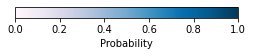

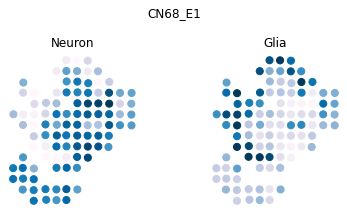

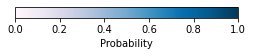

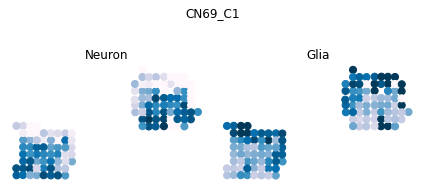

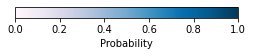

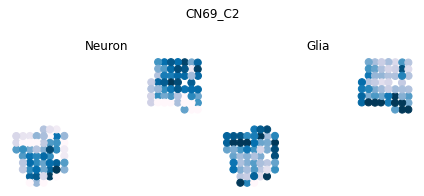

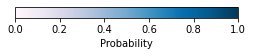

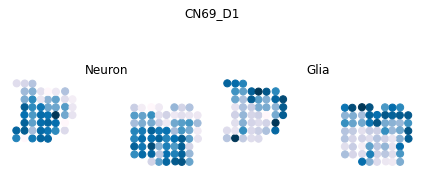

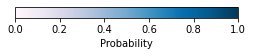

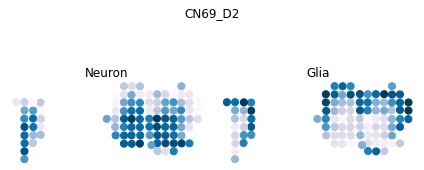

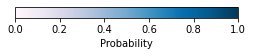

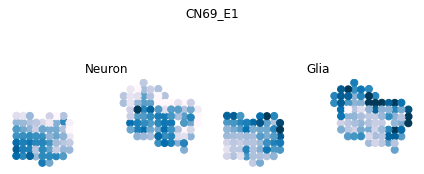

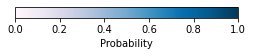

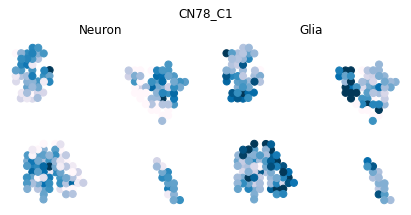

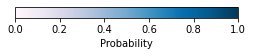

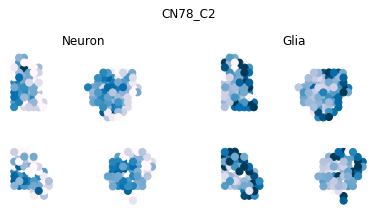

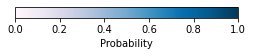

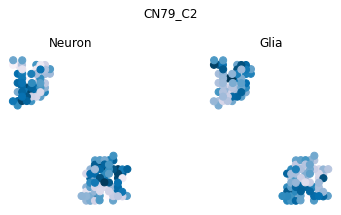

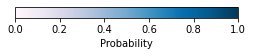

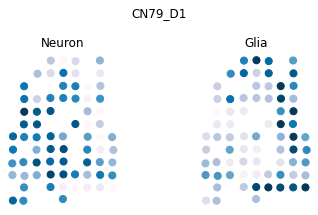

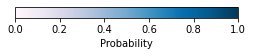

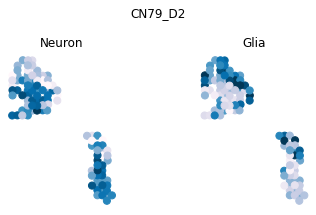

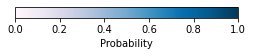

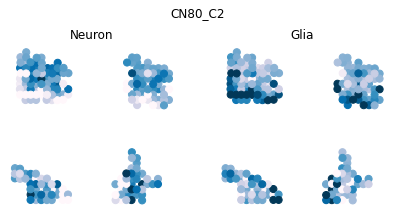

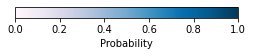

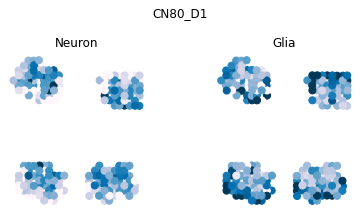

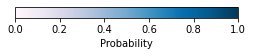

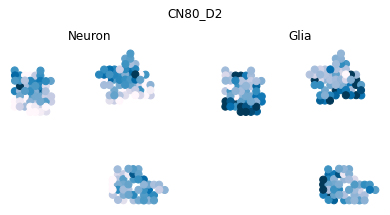

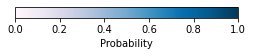

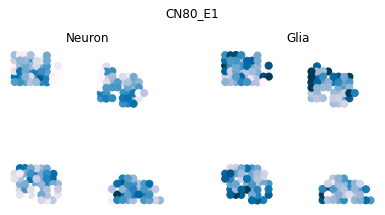

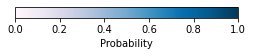

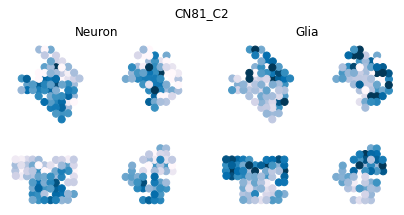

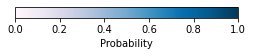

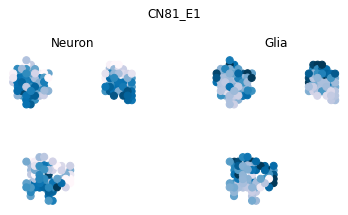

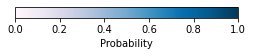

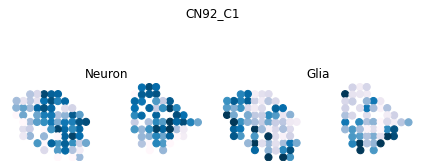

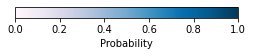

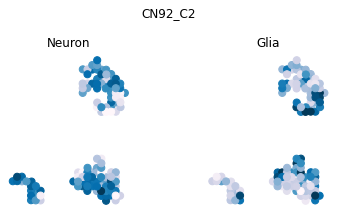

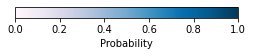

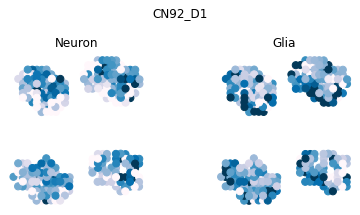

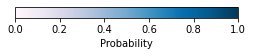

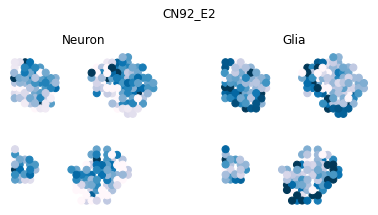

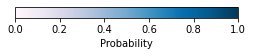

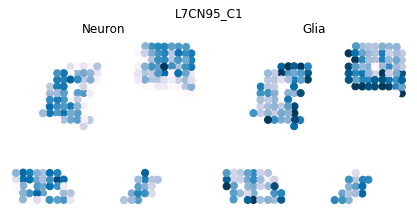

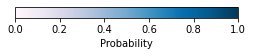

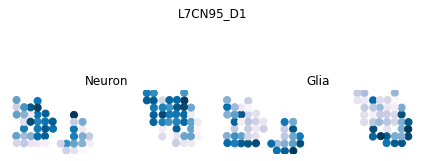

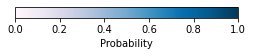

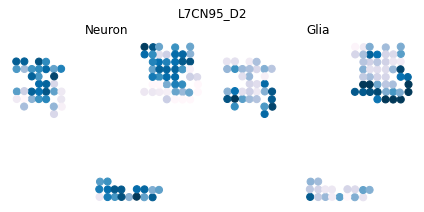

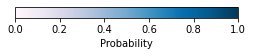

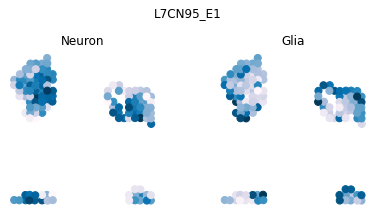

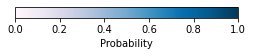

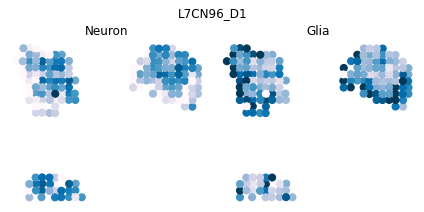

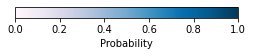

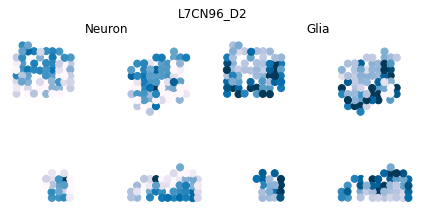

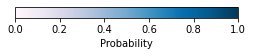

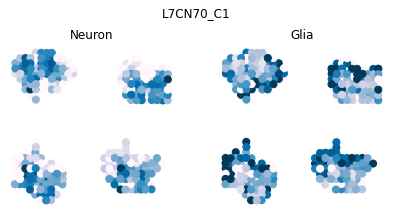

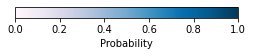

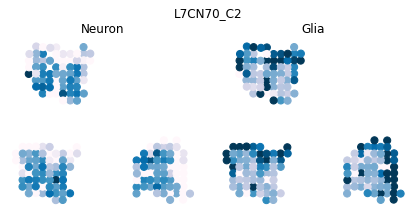

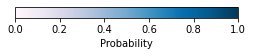

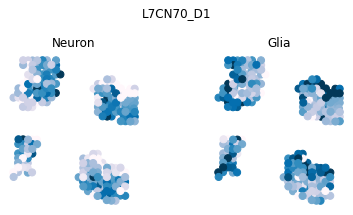

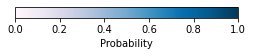

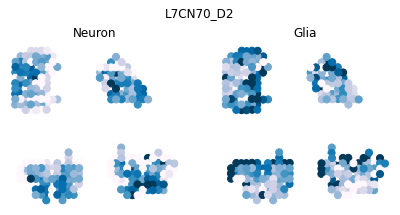

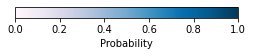

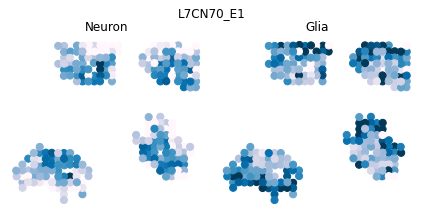

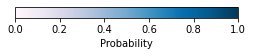

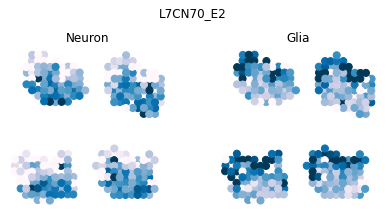

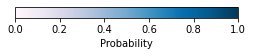

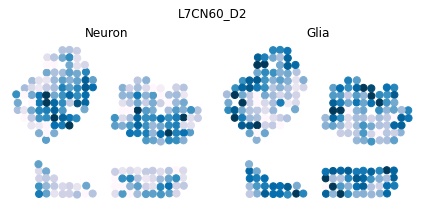

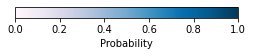

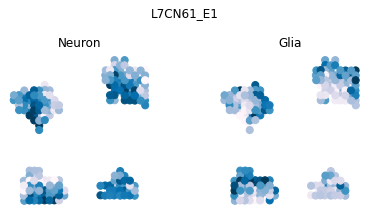

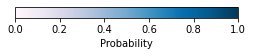

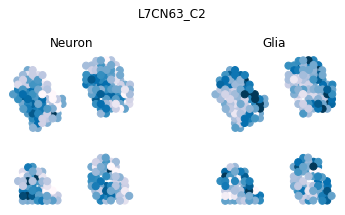

In [84]:
# Get percentages of each cell type in each spot after deconvolution
celltype_names = ['Neuron', 'Glia']

for array_name in cell_mappings.keys():
    tot_cells = np.sum([cell_mappings[array_name][ct] for ct in celltype_names], axis=0)
    tot_cells[tot_cells==0] = 1  # Deal with divide by zeros
    
    mapping_pct = pd.DataFrame({
        'x': cell_mappings[array_name]['x'],
        'y': cell_mappings[array_name]['y'],
    }, index=cell_mappings[array_name].index)
    for ct in celltype_names:
        mapping_pct[ct] = cell_mappings[array_name][ct] / tot_cells
    
    mapping_pct.drop(['x', 'y'], axis=1).transpose().to_csv('tangram_annots_%s.tsv' % array_name, sep='\t')
    
    plot_utils.plot_decon_annotations(mapping_pct, nrows=1, ncols=2, robust=True, perc=0.05, s=50, cmap='PuBu')
    plt.suptitle(array_name)
    plt.tight_layout()
    plt.show()